# **Работа с самим блокнотом**

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import torch

In [ ]:
# 1. Загрузка данных
# Допустим, у нас есть датасет в формате numpy: x_train (набор изображений)

# Загрузим датасет для примера (здесь мы используем MNIST для упрощения)
(x_train, _), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 28, 28, 1))

# 2. Создание модели VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 2  # Размерность латентного пространства

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder


    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling((z_mean, z_log_var))
        return self.decoder(z)

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

tf.device('/GPU:0')

vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='mse')
# 3. Обучение VAE
vae.fit(x_train, x_train, epochs=10, batch_size=32)

# 4. Применение VAE для переноса стиля

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: 0.0560
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0453
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0435
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0426
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0419
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0415
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0411
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0408
Epoch 9/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0405
Epoch 10/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0403


In [ ]:
def transfer_style(content_image_path, style_image_path):
    content_image = image.load_img(content_image_path, target_size=(28, 28))
    content_image = image.img_to_array(content_image)
    content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2GRAY)
    content_image = content_image.astype('float32') / 255.
    content_image = np.expand_dims(content_image, axis=0)

    style_image = image.load_img(style_image_path, target_size=(28, 28))
    style_image = image.img_to_array(style_image)
    style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2GRAY)
    style_image = style_image.astype('float32') / 255.
    style_image = np.expand_dims(style_image, axis=0)

    content_encoded = encoder.predict(content_image)[0]
    style_encoded = encoder.predict(style_image)[0]

    # Здесь можно выполнить комбинирование латентных переменных для переноса стиля
    # Например, используя простое усреднение (для демонстрации)
    combined_encoded = (content_encoded + style_encoded) / 2.0

    transferred_image = decoder.predict(combined_encoded)

    return transferred_image

# # Применяем функцию для демонстрации переноса стиля
#result_image = transfer_style('path_to_content_image.jpg', 'path_to_style_image.jpg')

In [ ]:
# Применяем функцию для демонстрации переноса стиля
result_image = transfer_style('a.jpg', 'b.jpg')

1/1 [==============================] - 0s 129ms/step


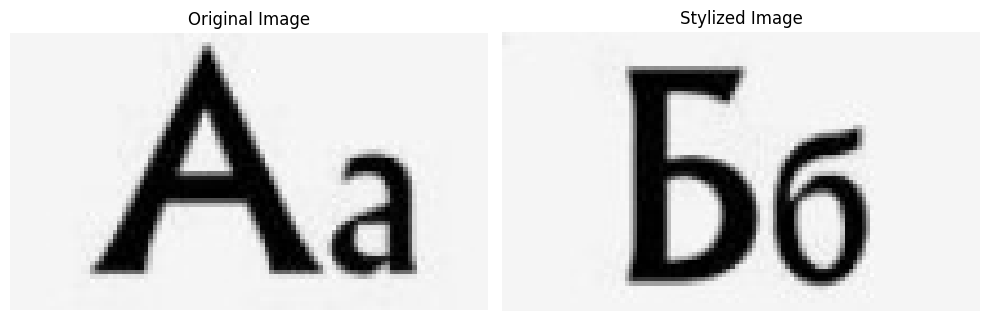

In [ ]:
import matplotlib.pyplot as plt

def display_images(original, stylized):
    plt.figure(figsize=(10, 5))

    # Отображение исходного изображения
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis('off')

    # Отображение стилизованного изображения
    plt.subplot(1, 2, 2)
    plt.imshow(stylized)
    plt.title("Stylized Image")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Пример использования
original_image = plt.imread('a.jpg')
stylized_image = plt.imread('b.jpg')
style_image_1 = style_image_1.astype(np.float32)[np.newaxis, ...] / 255.
style_image_2 = style_image_2.astype(np.float32)[np.newaxis, ...] / 255.

display_images(original_image, stylized_image)


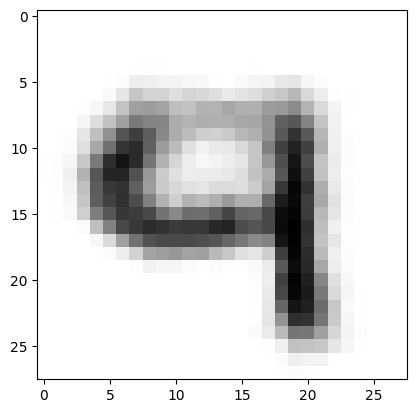

In [ ]:
plt.imshow(1-result_image[0,...], cmap='gray')
plt.show()

In [ ]:
result_image.shape

(1, 28, 28, 1)

# **Neural style transfer(Tensor Flow)**

https://www.tensorflow.org/tutorials/generative/style_transfer

In [ ]:
import os
import tensorflow as tf
import IPython.display as display
import numpy as np
import PIL.Image
import time
import functools

import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
tf.device('/GPU:0')

загрузка изображений(основного и стилей)

In [ ]:
content_image = plt.imread('minsk.jpg')
style_image_1  = plt.imread('an.jfif')
style_image_2  = plt.imread('more.jpg')
style_image_3  = plt.imread('es.jpg')

In [ ]:
content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
style_image_1 = style_image_1.astype(np.float32)[np.newaxis, ...] / 255.
style_image_2 = style_image_2.astype(np.float32)[np.newaxis, ...] / 255.
style_image_3 = style_image_3.astype(np.float32)[np.newaxis, ...] / 255.


перевод тензора к изображению

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

вывод изображения и стилей(3)

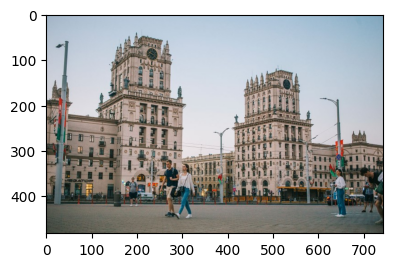

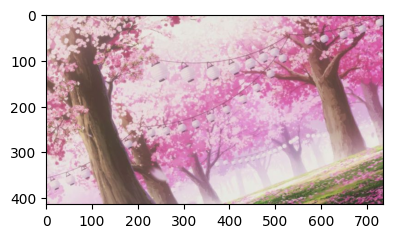

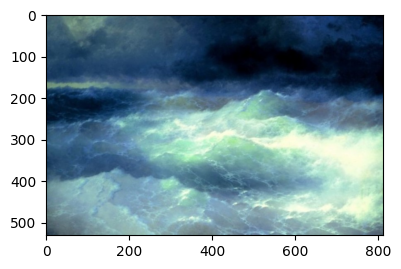

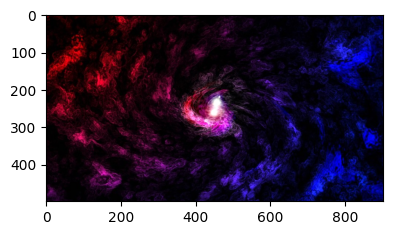

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(np.squeeze(content_image))
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,4,2)
plt.imshow(np.squeeze(style_image_1))
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,4,3)
plt.imshow(np.squeeze(style_image_2))
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1,4,4)
plt.imshow(np.squeeze(style_image_3))
plt.show()

импорт модели(kaggle) и ее использование

Быстрая передача стиля с помощью TF-Hub

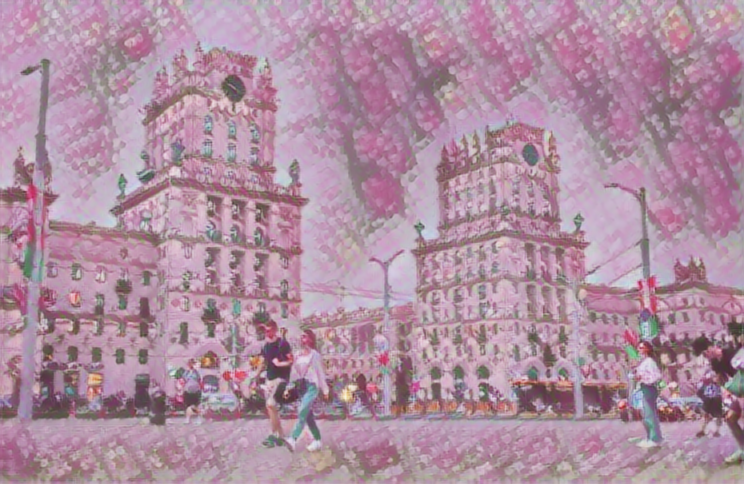

In [ ]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

stylized_image_1 = hub_model(tf.constant(content_image), tf.constant(style_image_1))[0]
tensor_to_image(stylized_image_1)


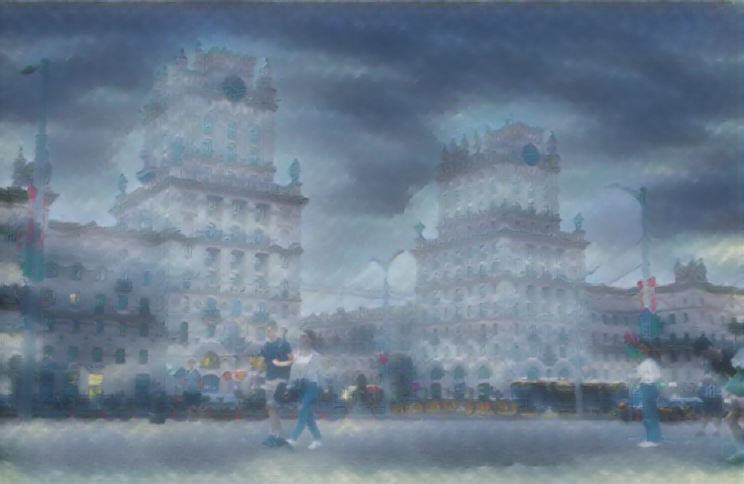

In [ ]:
stylized_image_2 = hub_model(tf.constant(content_image), tf.constant(style_image_2))[0]
tensor_to_image(stylized_image_2)

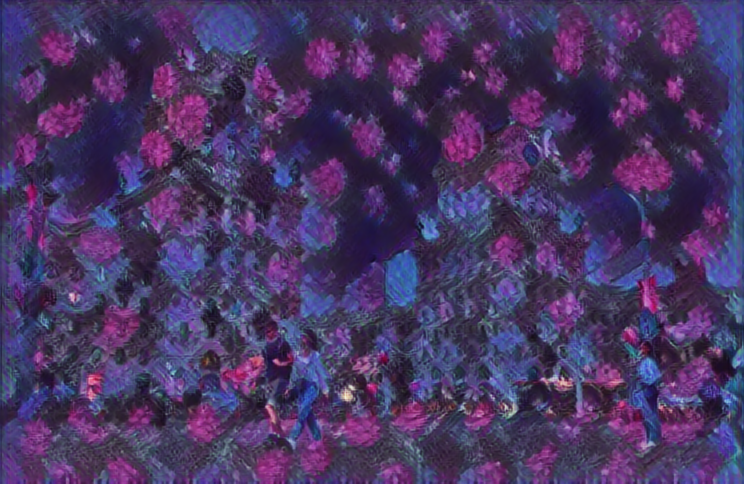

In [ ]:
stylized_image_3 = hub_model(tf.constant(content_image), tf.constant(style_image_3))[0]
tensor_to_image(stylized_image_3)

доработка с помощью использования VGG19 и ее промежуточных слоев, которые представляют из себя стиль и содержание изображения



In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

созднаие модели

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image_2*255)


Рассчет стилей

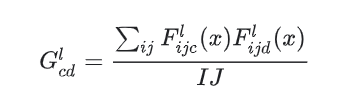

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Извлечение стилей и содержания

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

Градиентный спуск

In [ ]:
style_targets = extractor(style_image_2)['style']
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

длительная оптимизация

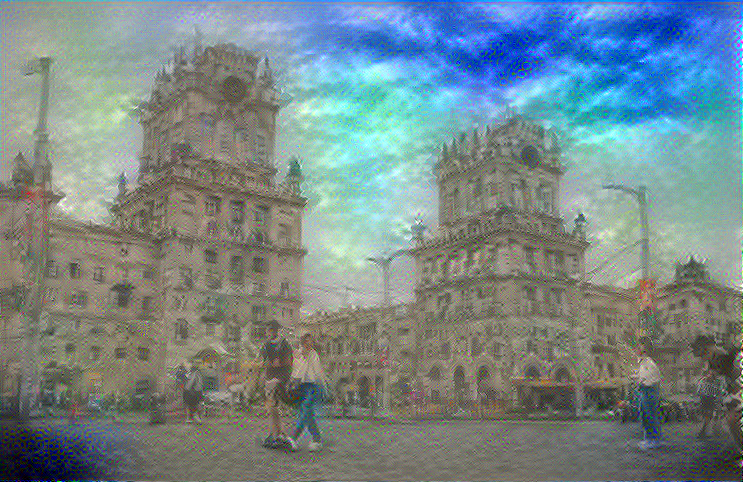

Train step: 1000
Total time: 172.0


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

**Избавление от арефактов**

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

156257.5

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

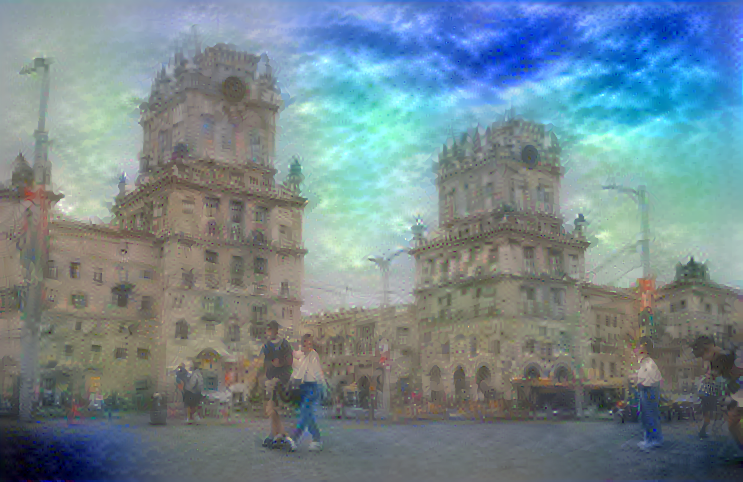

Train step: 1000
Total time: 162.5


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))